In [443]:
import glob
import rasterio
import matplotlib.pyplot as plt
import cv2

## Important

In [444]:
def calculate_black_pixel_percentage(image_array):
    """
    Calculate the percentage of black pixels (intensity 0) in the input image array.

    Args:
        image_array (numpy.ndarray): Grayscale or binary image array.

    Returns:
        percentage (float): Percentage of black pixels in the image.
    """
    if image_array.size == 0:
        return 0.0
    black_pixels = np.count_nonzero(image_array == 0)
    total_pixels = image_array.size
    percentage = (black_pixels / total_pixels) * 100
    return percentage

In [445]:
import numpy as np
from skimage.segmentation import slic
from scipy.ndimage import center_of_mass

def convert_image_array_to_slic_with_properties(image_array, binary_array, n_segments=100, compactness=10, sigma=1):
    """
    Convert an image array to a segmented RGB image using SLIC (Simple Linear Iterative Clustering) algorithm,
    and calculate properties for each superpixel including color, centroid x, centroid y, and number of pixels.

    Args:
        image_array (numpy.ndarray): Input RGB image array.
        binary_array (numpy.ndarray): Binary array of the same dimensions as the image.
        n_segments (int, optional): Number of segments in SLIC. Default is 100.
        compactness (float, optional): Compactness parameter for SLIC. Default is 10.
        sigma (float, optional): Sigma parameter for SLIC. Default is 1.

    Returns:
        segmented_image_rgb (numpy.ndarray): Segmented RGB image.
        properties (numpy.ndarray): Array of dictionaries containing properties for each superpixel.
        labels (numpy.ndarray): Array of labels for each superpixel.
    """
    segments = slic(image_array, n_segments=n_segments, compactness=compactness, sigma=sigma)
    segmented_image_rgb = np.zeros_like(image_array)
    properties = []  # List to store properties

    for segment_id in np.unique(segments):
        mask = segments == segment_id
        segment_rgb = image_array[mask]

        if np.any(mask):
            num_pixels = np.sum(mask)
            centroid = center_of_mass(mask)
            centroid_x, centroid_y = centroid
            mean_color = np.mean(segment_rgb, axis=0)

            properties.append({
                'color': mean_color,  # RGB color values
                'centroid_x': centroid_x,  # x coordinate of centroid
                'centroid_y': centroid_y,  # y coordinate of centroid
                'num_pixels': num_pixels  # number of pixels in superpixel
            })

            segmented_image_rgb[mask] = mean_color

    properties = np.array(properties)  # Convert properties list to numpy array

    labels = []
    for prop in properties:
        x, y = int(prop['centroid_x']), int(prop['centroid_y'])
        binary_color = binary_array[y, x]  # Assuming binary_array has the same dimensions as the image
        label = 1 if binary_color == 0 else 0
        labels.append(label)
    # properties.append(labels)
    return segmented_image_rgb, properties, labels


loading true images

In [446]:
# For images
path_to_folders_images = "Natural_False_Color/"
true_dataset = []

tif_files = glob.glob(path_to_folders_images + "*.TIF")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files:
    temp=rasterio.open(tif_file)
    red_band = temp.read(1)
    green_band = temp.read(2)
    blue_band = temp.read(3)
    temp.close()
    true = np.stack((red_band, green_band, blue_band), axis=-1)
    true_dataset.append(true)
    

# For labels
path_to_folders_labels = "Entire_scene_gts/"
label_dataset = []

tif_files = glob.glob(path_to_folders_labels + "*.TIF")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files:
    temp=rasterio.open(tif_file)
    label = temp.read(1)
    temp.close()
    label_dataset.append(label)
     
        
        
# making patches
patch_size = 512
num_rows = 16
num_cols = 15

true_patches = []
label_patches = []

for i in range(len(true_dataset)):
    for row in range(num_rows):
        for col in range(num_cols):
            start_row = row * patch_size
            end_row = start_row + patch_size
            start_col = col * patch_size
            end_col = start_col + patch_size
            
            patch = true_dataset[i][start_row:end_row, start_col:end_col]
            if calculate_black_pixel_percentage(patch) > 0.95:
                continue
            label_patch = label_dataset[i][start_row:end_row, start_col:end_col]
            true_patches.append(patch)
            label_patches.append(label_patch)


c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


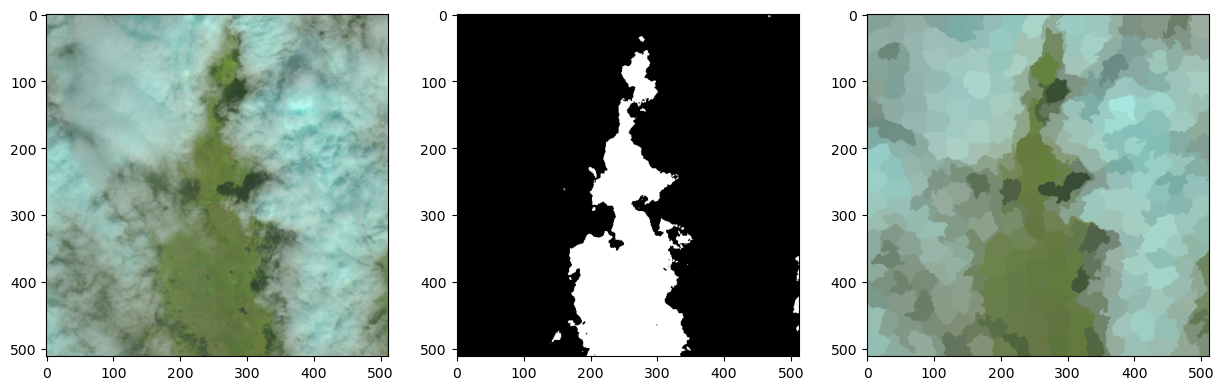

In [450]:
patch_number=1600

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(true_patches[patch_number],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(label_patches[patch_number],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(convert_image_array_to_slic_with_properties(image_array=true_patches[patch_number],binary_array=label_patches[patch_number],n_segments=300)[0],cmap='gray')
plt.show()

## IDK

In [188]:
true=rasterio.open("B02.tif").read(1)
label=rasterio.open("labels.tif").read(1)

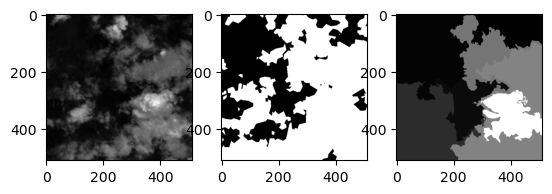

In [189]:
plt.subplot(1,3,1)
plt.imshow(true,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(label,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(convert_image_array_to_slic_with_properties(image_array=true,binary_array=label,n_segments=10)[0],cmap='gray')

In [296]:
true=rasterio.open("LC08_L1TP_002054_20160520_20170324_01_T1.TIF")
red_band = true.read(1)
green_band = true.read(2)
blue_band = true.read(3)
# Close the true when done
true.close()


# Stack the bands to create an RGB image
true = np.stack((red_band, green_band, blue_band), axis=-1)


label=rasterio.open("edited_corrected_gts_LC08_L1TP_002054_20160520_20170324_01_T1.tif").read(1)

c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [297]:
patch_size = 512
num_rows = 16
num_cols = 15

patches = []
label_patches = []

for row in range(num_rows):
    for col in range(num_cols):
        start_row = row * patch_size
        end_row = start_row + patch_size
        start_col = col * patch_size
        end_col = start_col + patch_size
        
        patch = true[start_row:end_row, start_col:end_col]
        if np.sum(patch) == 0:
            continue
        label_patch = label[start_row:end_row, start_col:end_col]
        patches.append(patch)
        label_patches.append(label_patch)

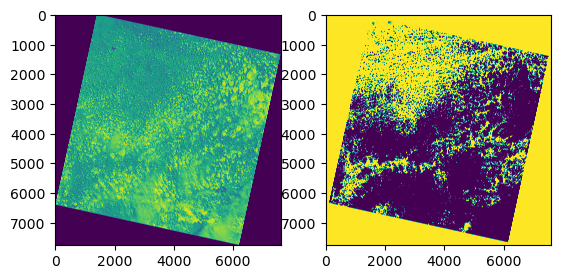

In [248]:
plt.subplot(1,2,1)
plt.imshow(true)
plt.subplot(1,2,2)
plt.imshow(label)

In [287]:
import numpy as np
from skimage.segmentation import slic
from scipy.ndimage import center_of_mass

def convert_image_array_to_slic_with_properties(image_array, binary_array, n_segments=100, compactness=10, sigma=1):
    """
    Convert an image array to a segmented RGB image using SLIC (Simple Linear Iterative Clustering) algorithm,
    and calculate properties for each superpixel including color, centroid x, centroid y, and number of pixels.

    Args:
        image_array (numpy.ndarray): Input RGB image array.
        binary_array (numpy.ndarray): Binary array of the same dimensions as the image.
        n_segments (int, optional): Number of segments in SLIC. Default is 100.
        compactness (float, optional): Compactness parameter for SLIC. Default is 10.
        sigma (float, optional): Sigma parameter for SLIC. Default is 1.

    Returns:
        segmented_image_rgb (numpy.ndarray): Segmented RGB image.
        properties (numpy.ndarray): Array of dictionaries containing properties for each superpixel.
        labels (numpy.ndarray): Array of labels for each superpixel.
    """
    segments = slic(image_array, n_segments=n_segments, compactness=compactness, sigma=sigma)
    segmented_image_rgb = np.zeros_like(image_array)
    properties = []  # List to store properties

    for segment_id in np.unique(segments):
        mask = segments == segment_id
        segment_rgb = image_array[mask]

        if np.any(mask):
            num_pixels = np.sum(mask)
            centroid = center_of_mass(mask)
            centroid_x, centroid_y = centroid
            mean_color = np.mean(segment_rgb, axis=0)

            properties.append({
                'color': mean_color,  # RGB color values
                'centroid_x': centroid_x,  # x coordinate of centroid
                'centroid_y': centroid_y,  # y coordinate of centroid
                'num_pixels': num_pixels  # number of pixels in superpixel
            })

            segmented_image_rgb[mask] = mean_color

    properties = np.array(properties)  # Convert properties list to numpy array

    labels = []
    for prop in properties:
        x, y = int(prop['centroid_x']), int(prop['centroid_y'])
        binary_color = binary_array[y, x]  # Assuming binary_array has the same dimensions as the image
        label = 1 if binary_color == 0 else 0
        labels.append(label)
    # properties.append(labels)
    return segmented_image_rgb, properties, labels


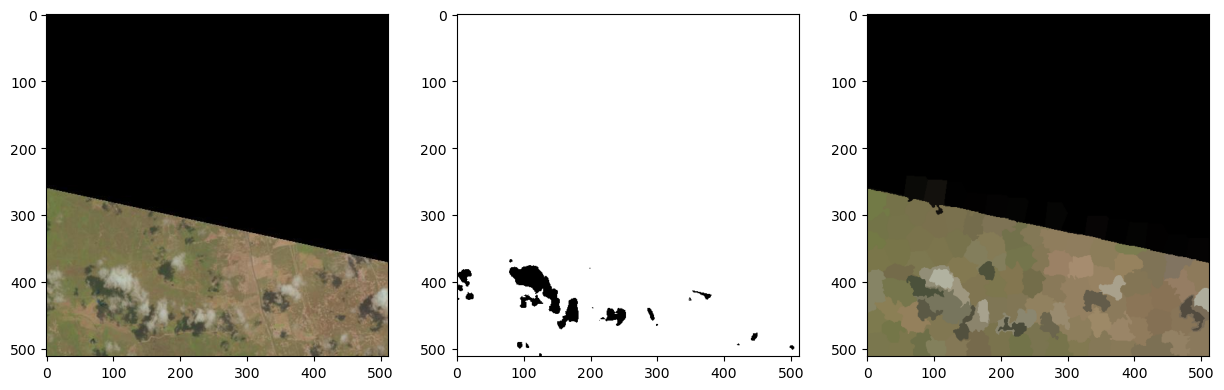

In [303]:
patch_number=3

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(patches[patch_number],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(label_patches[patch_number],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(convert_image_array_to_slic_with_properties(image_array=patches[patch_number],binary_array=label_patches[patch_number],n_segments=300)[0],cmap='gray')
plt.show()

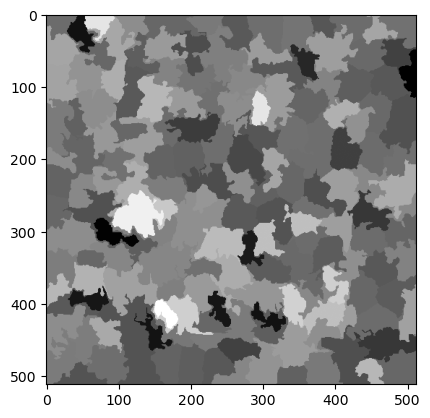

In [270]:
plt.imshow(convert_image_array_to_slic_with_properties(image_array=patches[19],binary_array=label_patches[19],n_segments=200)[0],cmap='gray')

In [291]:
np.mean(convert_image_array_to_slic_with_properties(image_array=patches[19],binary_array=label_patches[19],n_segments=200)[2])

0.06875

## DONT CARE

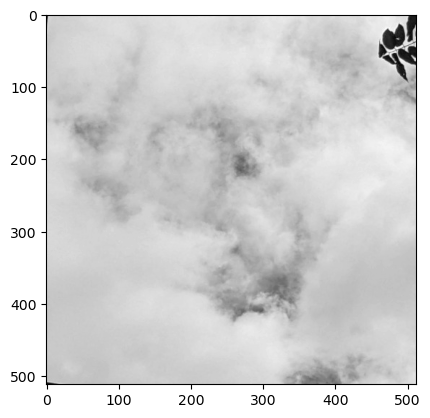

In [26]:
# Usage

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Load the JPEG image using PIL
image_path = 'gg.jpeg'  # Replace with the actual path to your JPEG image
image = Image.open(image_path)

# Convert the PIL image to a numpy array
image_arr = np.array(image)
image_arr=rgb2gray(image_arr)
plt.imshow(image_arr, cmap='gray')

In [114]:
import glob
import rasterio
import matplotlib.pyplot as plt

# Define the path to the folders containing the .tif files
path_to_folders = "D:/Anirudh/LMU DS/Sem2/CV/Project/otclouds/dataset_clouds_from_lwir/dataset_clouds_from_lwir/training/lwir"

# Use glob to find all the folders in the specified path
folder_paths = glob.glob(path_to_folders + "*/")

# Sort the folder paths alphabetically (assuming they are named sequentially)
folder_paths.sort()

# Initialize an empty list to store the first 10 datasets
datasets = []

# Iterate through the first 10 folders
for folder_path in folder_paths[:2]:
    # Use glob to find all .tif files within the folder
    tif_files = glob.glob(folder_path + "*.tif")
    tif_files.sort()  # Sort the .tif files alphabetically

    # Iterate through the .tif files and read them using rasterio
    for tif_file in tif_files:
        with rasterio.open(tif_file) as dataset:
            datasets.append(dataset.read(1))  # Append the data to the list


In [105]:
extreme=rasterio.open("LC08_L1TP_002054_20160520_20170324_01_T1.TIF").read(1)

c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [142]:
import glob
import rasterio
import matplotlib.pyplot as plt

# Define the path to the folders containing the .tif files
path_to_folders = "D:/Anirudh/LMU DS/Sem2/CV/Project/otclouds/dataset_clouds_from_lwir/dataset_clouds_from_lwir/training/lwir/"

# Initialize an empty list to store the first 10 datasets
datasets = []

tif_files = glob.glob(path_to_folders + "*.tif")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files[:100]:
    with rasterio.open(tif_file) as dataset:
        datasets.append(dataset.read(1))  # Append the data to the lis



c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


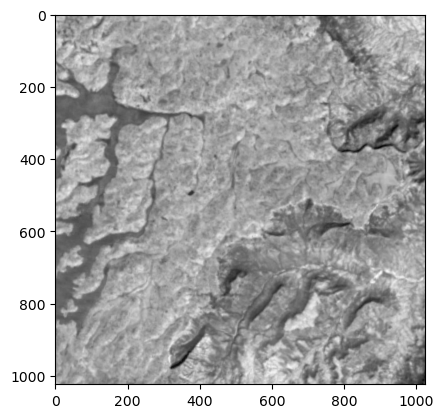

In [154]:
plt.imshow(datasets[77],cmap='gray')

In [133]:
import cv2
image = convert_image_array_to_slic_with_properties(datasets[7],n_segments=500)[0]
## min max scale the image
def min_max_scale(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def plot_thresholded_image(thresh,image=image):
    thresh = cv2.threshold(min_max_scale(image), thresh, 1, cv2.THRESH_BINARY)[1]

    ## Plot thresholded image
    plt.subplot(1,2,1)
    plt.imshow(datasets[7],cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(thresh,cmap='gray')
    plt.title('Thresholded Image')
    plt.show()
        

In [134]:
## Use funtion plot_thresholded_image with a ipython widget to find the best threshold value for the image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt

    
interact(plot_thresholded_image, image=widgets.fixed(image), thresh=(0, 1, 0.05))

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.05), Output()), _dom_classe…

<function __main__.plot_thresholded_image(thresh, image=array([[0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       [0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       [0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       ...,
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738],
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738],
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738]]))>

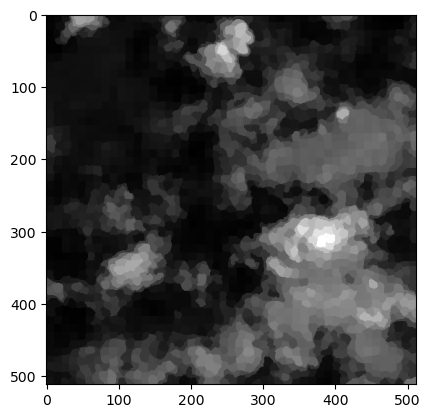

In [63]:
plt.imshow(convert_image_array_to_slic_with_properties(datasets[1],n_segments=2000)[0],cmap='gray')



In [32]:
convert_image_array_to_slic_with_properties(image_arr,n_segments=3)

(array([[0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        [0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        [0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        ...,
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407],
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407],
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407]]),
 array([{'color': array([0.73592292, 0.73592292, 0.73592292]), 'centroid_x': 180.44556840684635, 'centroid_y': 117.43895917157525, 'num_pixels': 79283},
        {'color': array([0.78066068, 0.78066068, 0.78066068]), 'centroid_x': 125.55159449658703, 'centroid_y': 377.14294475255974, 'num_pixels': 75008},
        {'color': array([0.73805407, 0.73805407, 0.73805407]), 'centroid_x': 401.04727731263847, 'centr